<h1>Loading Data</h1>

In [0]:
from google.colab import files
uploads=files.upload()

In [2]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 70 Dec 23 11:40 kaggle.json


In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!pip install kaggle

In [6]:
!kaggle datasets download -d snap/amazon-fine-food-reviews
#!kaggle competitions download -c tgs-salt-identification-challenge

 99% 249M/251M [00:05<00:00, 34.7MB/s]
100% 251M/251M [00:05<00:00, 44.1MB/s]


In [0]:
import zipfile
zip_ref = zipfile.ZipFile("amazon-fine-food-reviews.zip", 'r')
zip_ref.extractall("amazon")
zip_ref.close()

In [0]:

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3

import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle



In [0]:
con = sqlite3.connect('./amazon/database.sqlite') 

In [0]:
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con)

<h1>Data Preprocessing</h1>

In [0]:
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

In [0]:
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

In [0]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)


In [16]:
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)


In [18]:

final['Score'].value_counts()

positive    307063
negative     57110
Name: Score, dtype: int64

In [19]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:

stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')

def cleanhtml(sentence): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned


In [0]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) 
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) 
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence)
    
    
    final_string.append(str1)
    i+=1

In [0]:
final['CleanedText']=final_string 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [0]:
final_data=final.head(140000)

In [0]:
train_data=final_data.head(100000)
test_data=final_data[100000:140000]

In [26]:
train_data.shape

(100000, 11)

In [0]:
train_data.head()

In [0]:
def transform(x):
  if x=="positive":
    return 1
  else:
    return 0
  

In [0]:
train_data['Score']=train_data['Score'].apply(transform)
test_data['Score']=test_data['Score'].apply(transform)

In [0]:
y_train=np.array(train_data['Score'])
y_test=np.array(test_data['Score'])

<h1>Preparing Data For DL Model</h1>

In [0]:
word_corpus=dict()
for sent in train_data['CleanedText']:
  words=sent.split()
  for word in words:
    if word in word_corpus.keys():
      word_corpus[word]+=1
    else:
      word_corpus[word]=1
       

In [0]:
from operator import itemgetter
from collections import OrderedDict
sorted_word_corpus = sorted(word_corpus.items(), key=itemgetter(1),reverse=True)

In [0]:
words=[x[0] for x in sorted_word_corpus]
words=words[0:5000]

In [33]:
print(words[0:10])

['like', 'tast', 'tea', 'good', 'use', 'love', 'product', 'one', 'flavor', 'great']


In [0]:
row=[]
for sent in train_data['CleanedText']:
  _row=[]
  w=sent.split()
  for word in w:
    if word in words:
      index=words.index(word)
      _row.append(index)
  _row=set(_row)
  _row=list(_row)
  row.append(_row)
    

In [35]:
print(row[0])

[1536, 1282, 5, 11, 527, 788, 31, 938, 816, 1714, 179, 1207, 3259, 2622, 1229, 342, 87, 734, 2016, 98, 227, 1645, 1011, 1913, 1274, 2684]


In [0]:
X_train=np.array(row)

In [0]:
row_test=[]
for sent in test_data['CleanedText']:
  _row=[]
  w=sent.split()
  for word in w:
    if word in words:
      index=words.index(word)
      _row.append(index)
  _row=set(_row)
  _row=list(_row)
  row_test.append(_row)
    

In [0]:
X_test=np.array(row_test)

In [39]:
print("Max Length of words in train data",np.array([len(x) for x in X_train]).max())
print("Max Length of words in test data",np.array([len(x) for x in X_test]).max())


Max Length of words in train data 397
Max Length of words in test data 433


In [40]:
print(X_train.shape)
print(X_test.shape)

(100000,)
(40000,)


In [41]:
type(X_train[0])

list

<h1>LSTM</h1>

In [0]:
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Dropout

In [43]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [46]:
max_review_length = 433
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

print(X_train.shape)
print(X_train[1])

(100000, 433)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0   

In [0]:
top_words = 5000

In [47]:
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 433, 32)           160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


In [48]:
history = model.fit(X_train, y_train, nb_epoch=10, batch_size=500 ,verbose=1,validation_data=(X_test, y_test))
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 100000 samples, validate on 40000 samples
Epoch 1/10
100000/100000 [==============================] - 243s 2ms/step - loss: 0.3040 - acc: 0.8858 - val_loss: 0.2068 - val_acc: 0.9179
Epoch 2/10
100000/100000 [==============================] - 243s 2ms/step - loss: 0.1858 - acc: 0.9264 - val_loss: 0.2094 - val_acc: 0.9217
Epoch 3/10
100000/100000 [==============================] - 244s 2ms/step - loss: 0.1749 - acc: 0.9321 - val_loss: 0.2052 - val_acc: 0.9208
Epoch 4/10
100000/100000 [==============================] - 244s 2ms/step - loss: 0.1700 - acc: 0.9345 - val_loss: 0.2052 - val_acc: 0.9182
Epoch 5/10
100000/100000 [==============================] - 242s 2ms/step - loss: 0.1652 - acc: 0.9362 - val_loss: 0.2076 - val_acc: 0.9198
Epoch 6/10
100000/100000 [==============================] - 237s 2ms/step - loss: 0.1603 - acc: 0.9387 - val_loss: 0.2167 - val_acc: 0.9164
Epoch 7/10
100000/100000 [==============================] - 235s 2ms/step - loss: 0.1561 - acc: 0.9397 - val_

In [0]:
def plt_dynamic(x, vy, ty):
  plt.figure(figsize=(10,5))
  plt.plot(x, vy, 'b', label="Validation Loss")
  plt.plot(x, ty, 'r', label="Train Loss")
  plt.xlabel('Epochs') 
  plt.ylabel('Binary Crossentropy Loss')
  plt.title('Binary Crossentropy Loss VS Epochs')
  plt.legend()
  plt.show()

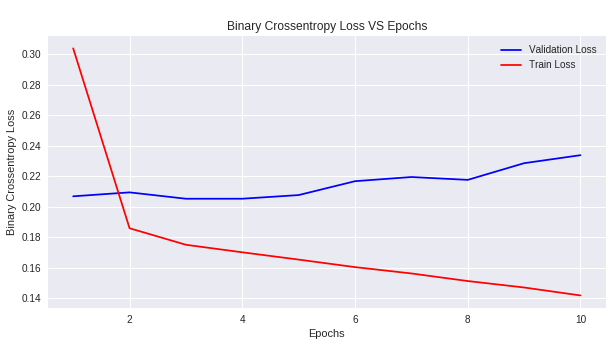

In [52]:
model_test = scores[1]
model_train = max(history.history['acc'])
x = list(range(1,11))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty)

In [63]:
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100,return_sequences=True,  recurrent_dropout=0.5))
model.add(Dropout(0.5))
model.add(LSTM(100 , recurrent_dropout=0.5))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 433, 32)           160000    
_________________________________________________________________
lstm_9 (LSTM)                (None, 433, 100)          53200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 433, 100)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 293,701
Trainable params: 293,701
Non-trainable params: 0
_________________________________________________________________


In [64]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, nb_epoch=10, batch_size=500 ,verbose=1,validation_data=(X_test, y_test))

Train on 100000 samples, validate on 40000 samples
Epoch 1/10
100000/100000 [==============================] - 506s 5ms/step - loss: 0.2974 - acc: 0.8899 - val_loss: 0.2134 - val_acc: 0.9144
Epoch 2/10
100000/100000 [==============================] - 512s 5ms/step - loss: 0.1987 - acc: 0.9228 - val_loss: 0.2096 - val_acc: 0.9180
Epoch 3/10
100000/100000 [==============================] - 522s 5ms/step - loss: 0.1862 - acc: 0.9278 - val_loss: 0.2118 - val_acc: 0.9199
Epoch 4/10
100000/100000 [==============================] - 522s 5ms/step - loss: 0.1800 - acc: 0.9308 - val_loss: 0.2132 - val_acc: 0.9189
Epoch 5/10
100000/100000 [==============================] - 523s 5ms/step - loss: 0.1749 - acc: 0.9328 - val_loss: 0.2160 - val_acc: 0.9186
Epoch 6/10
100000/100000 [==============================] - 517s 5ms/step - loss: 0.1708 - acc: 0.9343 - val_loss: 0.2189 - val_acc: 0.9160
Epoch 7/10
100000/100000 [==============================] - 517s 5ms/step - loss: 0.1667 - acc: 0.9367 - val_

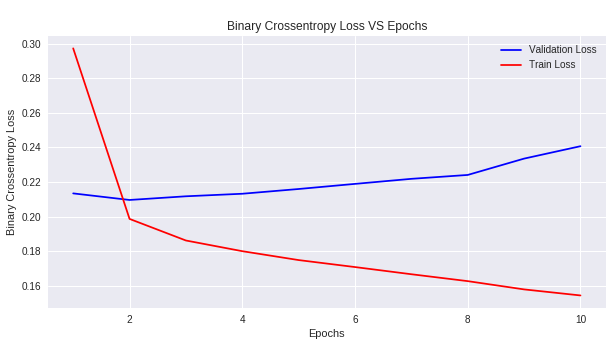

In [65]:
model_test = scores[1]
model_train = max(history.history['acc'])
x = list(range(1,11))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty)

# Report

Classifying Positive and Negative Reviews on  Amazon Fine Food Reviews dataset

Sort the dataset on the basis of time and after that find vocabulary for all the reviews in the dataset

computing  frequencies for each word of vocabulary

Index each word in the decreasing order of frequencies 

Convert the dataset into imdb dataset format

Select 0.1million ponts as  training_data 40K as test_data 

add Zero  padding is added to  each review intpo sequences of length 433 to perform batch wise input into LSTM

Implementing RNN with 1 , 2 LSTM layers

Draw Binary Crossentropy Loss VS No.of Epochs plot

In [0]:
from prettytable import PrettyTable

In [68]:
x = PrettyTable()

x.field_names = ["NO OF LSTM Layers",  "Metrics"]

x.add_row([1, "loss: 0.1544 - acc: 0.9409 - val_loss: 0.2407 - val_acc: 0.9149"])
x.add_row([2, "loss: 0.1417 - acc: 0.9457 - val_loss: 0.2338 - val_acc: 0.9138"])

print(x)

+-------------------+-----------------------------------------------------------------+
| NO OF LSTM Layers |                             Metrics                             |
+-------------------+-----------------------------------------------------------------+
|         1         | loss: 0.1544 - acc: 0.9409 - val_loss: 0.2407 - val_acc: 0.9149 |
|         2         | loss: 0.1417 - acc: 0.9457 - val_loss: 0.2338 - val_acc: 0.9138 |
+-------------------+-----------------------------------------------------------------+
